# Classical approaches

### Upload file on google colaboratory (from google drive)

Original article [there](https://buomsoo-kim.github.io/colab/2018/04/16/Importing-files-from-Google-Drive-in-Google-Colab.md)

In [0]:
id_url = "1qEYzNSo0EBhU0XfxputYvXxBFJ-CZ5OX" #Enter your id of google drive document

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':id_url})

In [0]:
output_file = 'down.root'
downloaded.GetContentFile(output_file)

## Data preparation

In [6]:
!pip install uproot -q #for colab

     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 92kB 13.5MB/s 


In [0]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from google.colab.patches import cv2_imshow
from matplotlib.patches import Ellipse, Circle

%matplotlib inline

In [0]:
info_tree = uproot.open(output_file)['info_sim']
raw_tree = uproot.open(output_file)['raw_data']

Распечатаю информацию о моделироании

In [9]:
info_tree.pandas.df(flatten=True).head(1)

,,events,momentum,theta,phi,zDis,layers,layers.first,layers.second,name,num_side_x,num_side_y,gap,size,chip_num_size,chip_pitch,chip_size,chip_offset,focal_length,trg_window,origin_pos._2,origin_pos._1,origin_pos._0
entry,subentry,,,,,,,,,,,,,,,,,,,,,,
0,0,50000,1000.0,0.0,1.570796,1.0,4,1.041,9.32,b'SensL_ARRAYJ-30020-64P-PCB_25V',8,17,1.0,26.68,8,0.2,3.16,0.0,200.0,20.0,201.0,106.72,0.0


Превращаю в таблицу данные моделирования

In [10]:
fulldf = raw_tree.pandas.df()
fulldf.head(3)

id_event  id_primary  ...  hits.phi.first  hits.phi.second
entry subentry                        ...                                 
0     0                1        -211  ...             0.0              0.0
      1                1        -211  ...             0.0              0.0
      2                1        -211  ...             0.0              0.0

[3 rows x 34 columns]

In [11]:
fulldf.describe()

,id_event,id_primary,pos_primary._2,pos_primary._1,pos_primary._0,dir_primary._2,dir_primary._1,dir_primary._0,hits,hits.id_pmt,hits.id_chip,hits.id_layer,hits.id_track,hits.id_track_parent,hits.id_hit,hits.wavelength,hits.time,hits.pos_exact._2,hits.pos_exact._1,hits.pos_exact._0,hits.pos_chip._2,hits.pos_chip._1,hits.pos_chip._0,hits.pos_vertex._2,hits.pos_vertex._1,hits.pos_vertex._0,hits.dir_vertex._2,hits.dir_vertex._1,hits.dir_vertex._0,hits.theta.first,hits.theta.second,hits.phi.first,hits.phi.second
count,993407.000000,993407.000000,993407.0,993407.000000,993407.000000,993407.0,993407.0,993407.0,993407.000000,993407.000000,993407.000000,993407.000000,993407.000000,993407.000000,993407.0,993407.000000,993407.000000,993407.000000,993407.000000,993407.000000,9.934070e+05,993407.000000,993407.000000,993407.000000,993407.000000,993407.000000,993407.000000,993407.000000,993407.000000,993407.0,993407.0,993407.0,993407.0
mean,25035.193149,-211.588530,0.0,0.004829,-0.006412,1.0,0.0,0.0,40.765470,64.782044,32.552517,2.747392,245.442823,2.550117,0.0,427.671705,0.716711,201.000570,3.791223,0.015351,2.010500e+02,3.792310,0.015192,21.247246,0.011625,-0.004948,0.963746,0.002538,0.000148,0.0,0.0,0.0,0.0
std,14414.621555,8.024464,0.0,0.969555,0.969505,0.0,0.0,0.0,7.795391,23.256084,17.668222,1.101370,133.685231,19.852174,0.0,108.187371,0.087131,0.006132,47.696520,39.296890,2.496166e-09,47.718007,39.318050,9.932300,1.279194,1.160645,0.021641,0.187929,0.188154,0.0,0.0,0.0,0.0
min,1.000000,-321.000000,0.0,-1.679763,-1.679778,1.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.0,200.049021,0.671925,201.000000,-128.059814,-110.216036,2.010500e+02,-126.480000,-108.640000,1.000155,-93.654610,-84.189243,-0.983523,-0.999515,-0.998301,0.0,0.0,0.0,0.0
25%,12664.000000,-211.000000,0.0,-0.827906,-0.845975,1.0,0.0,0.0,36.000000,40.000000,17.000000,2.000000,137.000000,1.000000,0.0,348.774747,0.696598,201.000000,-35.261286,-37.159636,2.010500e+02,-36.720000,-36.480000,13.241316,-0.835164,-0.851899,0.962136,-0.179502,-0.187729,0.0,0.0,0.0,0.0
50%,24856.000000,-211.000000,0.0,-0.000010,-0.015476,1.0,0.0,0.0,40.000000,68.000000,33.000000,3.000000,253.000000,1.000000,0.0,410.311039,0.697337,201.000000,1.651972,-0.505239,2.010500e+02,1.040000,-2.080000,22.538553,0.001009,-0.014494,0.964887,0.002793,0.000080,0.0,0.0,0.0,0.0
75%,37516.000000,-211.000000,0.0,0.842198,0.831608,1.0,0.0,0.0,45.000000,89.000000,48.000000,4.000000,353.000000,1.000000,0.0,483.119867,0.698236,201.000000,38.443551,37.230225,2.010500e+02,39.600000,36.480000,29.958778,0.851051,0.839157,0.967844,0.183594,0.188108,0.0,0.0,0.0,0.0
max,50000.000000,-211.000000,0.0,1.679900,1.679988,1.0,0.0,0.0,113.000000,136.000000,64.000000,4.000000,4301.000000,2625.000000,0.0,899.990047,3.009657,201.099998,341.430033,110.218249,2.010500e+02,339.920000,108.640000,35.999992,93.090047,80.333879,0.999997,0.998824,0.991826,0.0,0.0,0.0,0.0


In [0]:
df = raw_tree.pandas.df(branches=['hits.pos_chip._0', 'hits.pos_chip._1', 'hits.pos_vertex._0', 'hits.pos_vertex._1'])
df = df.rename({'hits.pos_chip._0':'chip_x', 'hits.pos_chip._1':'chip_y', 'hits.pos_vertex._0':'vertex_x', 'hits.pos_vertex._1':'vertex_y'}, axis=1)

In [0]:
data = df.groupby('entry').agg({'chip_x': list, 'chip_y': list, 'vertex_x': 'mean', 'vertex_y': 'mean'})

In [14]:
data.head()

,chip_x,chip_y,vertex_x,vertex_y
entry,,,,
0,"[-98.55999999999999, -36.47999999999999, -36.4...","[-67.75999999999999, -33.36000000000001, -33.3...",1.609652,1.125650
2,"[-85.11999999999999, -85.11999999999999, -57.4...","[129.35999999999999, 205.67999999999995, 118.4...",0.241547,0.048154
3,"[-33.11999999999999, -36.47999999999999, -43.1...","[-40.080000000000005, -30.000000000000007, -23...",1.526540,0.478399
4,"[-91.83999999999999, -85.11999999999999, -77.6...","[-85.35999999999999, 74.0, -30.000000000000007...",1.102120,-1.260826
8,"[-33.11999999999999, -39.839999999999996, -49....","[-40.080000000000005, -30.000000000000007, -19...",0.040140,-0.860000


Теперь у меня подготовленные данные. Разобью таблицу на `train` и `test` части. Финальный результат буду формировать по результатам на `test`. Так можно будет сравнивать подходы

In [0]:
from sklearn.model_selection import train_test_split
X = data[['chip_x', 'chip_y']]
y = data[['vertex_x', 'vertex_y']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Пример события

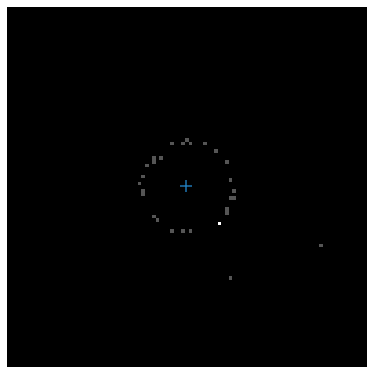

In [16]:
loc_ind = 15940 # 21
x = data['chip_x'].loc[loc_ind]
y = data['chip_y'].loc[loc_ind]
xv = data['vertex_x'].loc[loc_ind]
yv = data['vertex_y'].loc[loc_ind]
xedges = np.linspace(-200, 200, 100)
yedges = np.linspace(-200, 200, 100)
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))

fig = plt.figure(frameon=False, figsize=(5, 5) )
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, H, cmap='gray')
plt.scatter(xv, yv, marker='+', s=150) #mean vertex
# fig.savefig('data.png', dpi=40) #real figure size = figsize*dpi

## Подходы

### FitEllipse
____
фитирование эллипса методом наименьших квадратов

дополнительно используется `hit-or-miss` фильтр, чтоб избежать негативного воздействия шумов на фит эллипса

In [0]:
def hit_or_miss_cleaner(img, kernel_size=9):
    kernel = (np.zeros((kernel_size,kernel_size))-1).astype('int')
    c = (kernel_size-1)//2
    kernel[c, c] = 1
    dst = cv2.morphologyEx(img, cv2.MORPH_HITMISS, kernel)
    dst = cv2.bitwise_not(dst)
    dst = cv2.bitwise_and(img, dst)
    return dst

def ellipse_finder(img, kernel_size):
    dst = hit_or_miss_cleaner(img, kernel_size)
    nzs= cv2.findNonZero(dst)
    try:
        ellipse = cv2.fitEllipse(nzs)
        ellipse = ( [ellipse[0][0]-len(img)//2, ellipse[0][1]-len(img)//2], [ellipse[1][0]*4, ellipse[1][1]*4], ellipse[2] ) 
    except:
        ellipse = ( [0, 0], [0, 0], 0)
    return ellipse, dst

def show_picture(ellipse, img, xedges, yedges, ax):
    X, Y = np.meshgrid(xedges, yedges)

    ax.set_axis_off()
    ax.pcolormesh(X, Y, img, cmap='gray')
    e = Ellipse(xy=(ellipse[0][0], ellipse[0][1]), width=ellipse[1][0], height=ellipse[1][1],\
                angle=ellipse[2], linewidth=2, fill=False, edgecolor='green', alpha=0.5)
    ax.add_artist(e)
    return

def get_image_from_row(loc_ind, X):
    x = X['chip_x'].iloc[loc_ind]
    y = X['chip_y'].iloc[loc_ind]
    xedges = np.linspace(-200, 200, 100)
    yedges = np.linspace(-200, 200, 100)
    H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))
    img = (np.where(H>0, 255, 0)).astype(np.uint8)
    return (img, xedges, yedges)

def full_finder(loc_ind, X, kernel_size=20, return_images=True):
    img, xedges, yedges = get_image_from_row(loc_ind, X)
    ellipse, dst = ellipse_finder(img, kernel_size)
    return (ellipse, [img, dst, xedges, yedges]) if return_images else ellipse

#### Пример

Left image: **original**, 

Right image: **filtered**

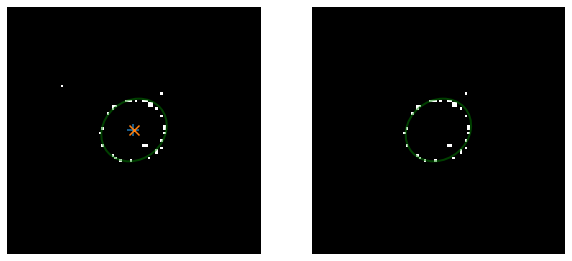

In [98]:
index = 52

ellipse, imgs = full_finder(index, X_train, 9, return_images=True)
fig = plt.figure(frameon=False, figsize=(10, 10) )
ax = plt.subplot(221)
show_picture(ellipse, imgs[0], imgs[2], imgs[3], ax)
ax.scatter(y_train['vertex_x'].iloc[index], y_train['vertex_y'].iloc[index], marker='+', s=150) #mean vertex
ax.scatter(ellipse[0][0], ellipse[0][1], marker='x', s=100) #mean vertex
ax2 = plt.subplot(222)
show_picture(ellipse, imgs[1], imgs[2], imgs[3], ax2)

#### Теперь реальный тест

In [0]:
y_test = y_test.reset_index(drop=True)

In [0]:
y_pred = pd.DataFrame( np.array( [ full_finder(i, X_test, 9, False)[0] for i in range(len(y_test)) ] ), columns=['vx_pred', 'vy_pred'] )

In [0]:
result_table = pd.concat([y_pred, y_test], axis=1)

In [92]:
result_table.head()

,vx_pred,vy_pred,vertex_x,vertex_y
0,-1.173809,1.203239,-0.036290,-0.710359
1,-0.090424,0.347160,1.601843,-0.208572
2,-0.363186,-0.101208,-0.172490,-1.315418
3,0.031689,0.323521,-0.087167,1.020302
4,-0.193245,-0.035778,0.381520,-0.699719


In [0]:
r = result_table
r['distance'] = np.sqrt( (r['vx_pred']-r['vertex_x'])**2 + (r['vy_pred']-r['vertex_y'])**2 )

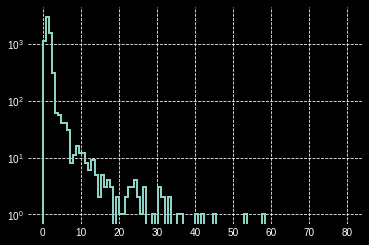

In [130]:
plt.style.use('dark_background')
plt.hist(r.distance, histtype='step', bins=100, range=(0, 80), lw=2);
plt.grid(linestyle='--')
plt.yscale('log')

**Результат**

In [116]:
r.distance.describe()

count    6377.000000
mean        1.925126
std         8.723894
min         0.050774
25%         0.959652
50%         1.364736
75%         1.806107
max       633.223336
Name: distance, dtype: float64

In [131]:
r.sort_values(by='distance', ascending=False).head(5)

,vx_pred,vy_pred,vertex_x,vertex_y,distance
5970,-425.920685,-469.853516,-0.612496,-0.721618,633.223336
3985,-199.861023,0.332561,1.126309,-0.593495,200.989465
1410,56.231964,-1.925259,-1.695329,3.423118,58.173675
2271,-50.607555,-10.292282,1.105676,1.615119,53.066416
1235,46.485474,3.795773,1.687192,-0.660953,45.019423


По индексу можно посмотреть некоторые конкретные ситуации

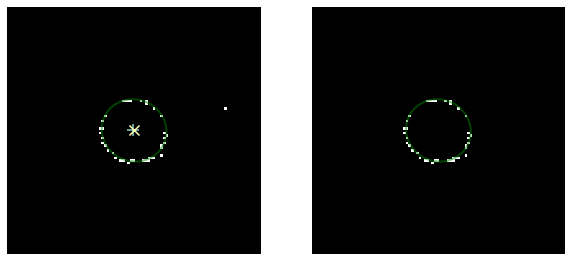

In [138]:
index = 5202

ellipse, imgs = full_finder(index, X_test, 9, return_images=True)
fig = plt.figure(frameon=False, figsize=(10, 10) )
ax = plt.subplot(221)
show_picture(ellipse, imgs[0], imgs[2], imgs[3], ax)
ax.scatter(y_test['vertex_x'].iloc[index], y_test['vertex_y'].iloc[index], marker='+', s=150) #mean vertex
ax.scatter(ellipse[0][0], ellipse[0][1], marker='x', s=100) #mean vertex
ax2 = plt.subplot(222)
show_picture(ellipse, imgs[1], imgs[2], imgs[3], ax2)

### Hough transform
___
Преоразование Хафа - возможно искать только круги (не эллипсы), но пока этого достаточно

дополнительно тоже `hit-or-miss` фильтр

In [0]:
def full_hough(loc_ind, X, kernel_size=9, return_image=True):
    img, xedges, yedges = get_image_from_row(loc_ind, X)
    dst = hit_or_miss_cleaner(img, kernel_size)
    for i in range(1, 10):
        circles = cv2.HoughCircles( img, cv2.HOUGH_GRADIENT, i, 1, param1=250, param2=30, minRadius=0, maxRadius=100)
        try:
            circle = circles[0][0]
            circle[0] -= 50
            circle[1] -= 50
            return (circle, [img, dst, xedges, yedges]) if return_image else circle #WARNING: what image should i choose?
        except:
            continue
    circle = np.array([0,0,0])
    return ( circle, [img, dst, xedges, yedges]) if return_image else circle

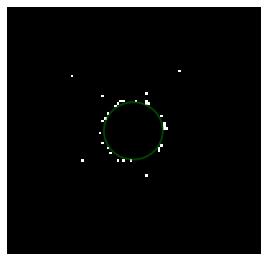

In [319]:
circle, imgs = full_hough(115, X_train, kernel_size=9, return_image=True)
X, Y = np.meshgrid(imgs[2], imgs[3])
fig = plt.figure(frameon=False, figsize=(10, 10) )
ax = plt.subplot(221)
ax.set_axis_off()
e = Circle(xy=(circle[0], circle[1]), radius=circle[2]*4, linewidth=2, fill=False, edgecolor='green', alpha=0.5)
ax.add_artist(e)
ax.pcolormesh(X, Y, img, cmap='gray')

In [0]:
y_pred = pd.DataFrame( np.array( [ full_hough(i, X_test, 9, False)[:2] for i in range(len(y_test)) ] ), columns=['vx_pred', 'vy_pred'] )

In [0]:
result_table = pd.concat([y_pred, y_test], axis=1)
r = result_table
r['distance'] = np.sqrt( (r['vx_pred']-r['vertex_x'])**2 + (r['vy_pred']-r['vertex_y'])**2 )

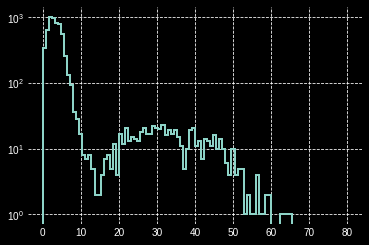

In [324]:
plt.style.use('dark_background')
plt.hist(r.distance, histtype='step', bins=100, range=(0, 80), lw=2);
plt.grid(linestyle='--')
plt.yscale('log')

**Результат**

In [325]:
r.distance.describe()

count    6377.000000
mean        6.349876
std         9.762991
min         0.014949
25%         2.091610
50%         3.375264
75%         5.017942
max        65.289649
Name: distance, dtype: float64